In [1]:
#interactive widgets in vs code
%matplotlib widget

#dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import bagpy
from bagpy import bagreader


In [21]:
# Read rosbag data
bag = bagreader("data/test2.bag")
#bag.topic_table

[INFO]  Data folder data/test2 already exists. Not creating.


In [22]:
# extract acceleration data, and convert to pandas dataframe
accel_df = pd.read_csv(bag.message_by_topic('/imu/acceleration'))
accel_df.head(3)

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,vector.x,vector.y,vector.z
0,1.669803e+09,258,1669803496,146093128,imu_link,1.556361,0.421717,9.577875
1,1.669803e+09,259,1669803496,151411847,imu_link,1.565144,0.374798,9.597023
2,1.669803e+09,260,1669803496,156716359,imu_link,1.604542,0.372322,9.621038


In [23]:
# extract angular velocities, and convert to pandas dataframe
gyro_df = pd.read_csv(bag.message_by_topic('/imu/angular_velocity'))
gyro_df.head(3)

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,vector.x,vector.y,vector.z
0,1.669803e+09,258,1669803496,146093128,imu_link,0.002259,-0.007393,0.014120
1,1.669803e+09,259,1669803496,151411847,imu_link,0.001877,-0.005862,0.008586
2,1.669803e+09,260,1669803496,156716359,imu_link,0.004171,-0.005834,0.018378


In [24]:
# calculate time difference between measurements
accel_df['time_diff_ns'] = accel_df['header.stamp.secs'].diff(1) + accel_df['header.stamp.nsecs'].diff(1) / 1e9
timesteps = accel_df['time_diff_ns'].to_numpy()     # get array and convert to numpy

# take rolling average of IMU data and store to numpy array, this is to filter noise
averaging_window = 10
vec_accel_raw = accel_df[['vector.x', 'vector.y', 'vector.z']].rolling(averaging_window).mean().to_numpy()
vec_gyro_raw = gyro_df[['vector.x', 'vector.y', 'vector.z']].rolling(averaging_window).mean().to_numpy()

# drop nan values
timesteps = timesteps[averaging_window:]
vec_accel_raw = vec_accel_raw[averaging_window:]
vec_gyro_raw = vec_gyro_raw[averaging_window:]

In [25]:
# do calibrations based on scale and bias values
accel_bias =  np.array([ 0.004432,  0.009620, -0.011343])
accel_scale = np.array([ 0.000081, -0.000767,  0.000080])
gyro_bias =   np.array([-0.003728,  0.000588, -0.001389])
#gyro_scale =  np.array([-1.008336, -1.003484, -1.010797])  #unreasonable values, ignore
gyro_scale =  np.array([0, 0, 0])

vec_accel = accel_bias + (1 + accel_scale) * vec_accel_raw
vec_gyro = gyro_bias + (1 + gyro_scale) * vec_gyro_raw

vec_accel[:, 2] -= 9.8 # subtract gravity from z

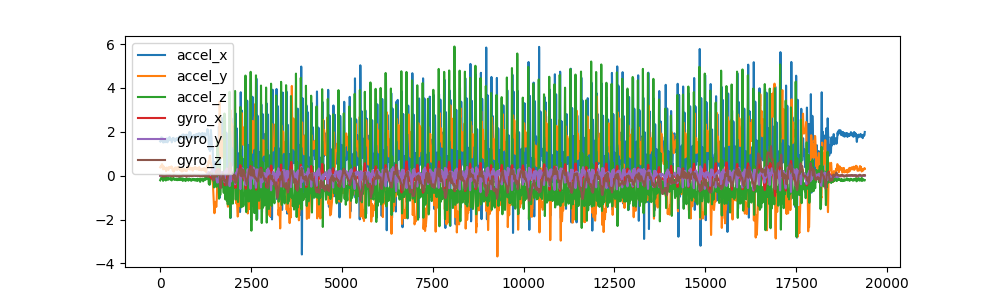

In [26]:
# plot the data to get an idea of the values
plt.figure(figsize=(10, 3))
plt.plot(vec_accel)
plt.plot(vec_gyro)
plt.legend(['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z'])
plt.show()

In [36]:
# integrate angular velocity to find rotation (multiply with timestep, then cumulative sum)
vec_rotation = np.cumsum(vec_gyro * timesteps[:,np.newaxis], axis=0)
vec_velocity = np.cumsum(vec_accel * timesteps[:,np.newaxis], axis=0)
vec_velocity = np.ones_like(vec_velocity)
vec_velocity[:, 2] = 0

# rotation calculations
vec_velocity_rotated = np.zeros_like(vec_velocity)
for nr, rotation_measure in enumerate(vec_rotation):    # loop over vectors
    roll, pitch, yaw = rotation_measure
    rollMatrix = np.matrix([                    # rotation about x
        [1, 0,             0           ],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll),  np.cos(roll)]])
    pitchMatrix = np.matrix([                   # rotation about y
        [ np.cos(pitch), 0, np.sin(pitch)],
        [0,              1,  0           ],
        [-np.sin(pitch), 0, np.cos(pitch)]])
    yawMatrix = np.matrix([                     # rotation about z
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw),  np.cos(yaw), 0],
        [0,            0,           1]])

    R = yawMatrix * pitchMatrix * rollMatrix        # combined rotation matrix
    velocity_rotated = np.matmul(R, vec_velocity[nr])     # matrix multiplication with accel vector

    vec_velocity_rotated[nr, :] = velocity_rotated        # add to array


In [37]:
# do some integrations on the velocity/position data
vec_position = np.cumsum(vec_velocity_rotated * timesteps[:,np.newaxis], axis=0)

In [38]:
# calculate magnitude of drift
start_pos = vec_position[:500].mean(axis=0)
end_pos = vec_position[-500:].mean(axis=0)

drift = end_pos - start_pos
drift

array([ -0.29724809,  24.46393989, -40.98174525])

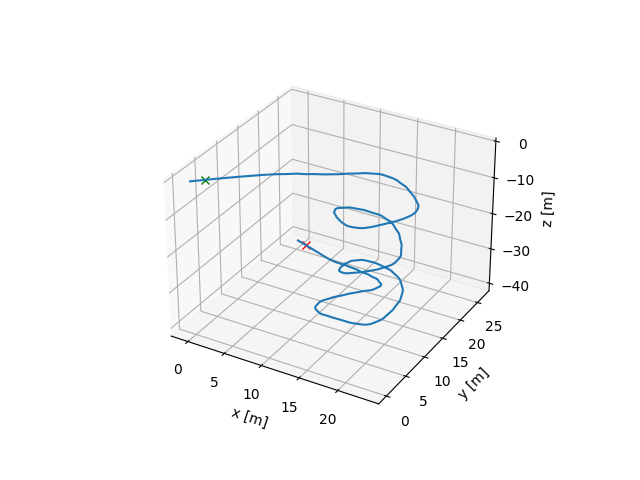

In [39]:
# plot it
fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = vec_position[:, 0]
ydata = vec_position[:, 1]
zdata = vec_position[:, 2]

ax.plot(*start_pos, 'gx')
ax.plot(*end_pos, 'rx')
ax.plot(xdata, ydata, zdata)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
plt.show()